# Human-evaluation

# STEP 1 — Setup: imports, project paths, and input checks

In [59]:

import ast
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd


def find_project_root(start: Path) -> Path:
    """
    Find the repository root by walking upward until both
    'inputs/' and 'outputs/' directories are found.
    """
    cur = start.resolve()
    for _ in range(25):
        if (cur / "inputs").is_dir() and (cur / "outputs").is_dir():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError(
  
    )


ROOT = find_project_root(Path.cwd())

# Inputs (downloaded dataset)
DATASET_DIR = ROOT / "inputs" / "dataset"
INPUT_BRANCH = "primary"  
PRIMARY_DIR = DATASET_DIR / INPUT_BRANCH / "primary-human-evaluation"
# Outputs 
OUT_DIR = ROOT / "outputs" / "human-evaluation"
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
# Input files 
EVAL_FILE = PRIMARY_DIR / "data-1760978361180.csv"
BG_FILE   = PRIMARY_DIR / "data-1760978508376.csv"
# Create output dirs
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print(f"ROOT       : {ROOT}")
print(f"PRIMARY_DIR: {PRIMARY_DIR}")
print(f"OUT_DIR    : {OUT_DIR}")
print(f"EVAL_FILE  : exists={EVAL_FILE.exists()}  path={EVAL_FILE}")
print(f"BG_FILE    : exists={BG_FILE.exists()}    path={BG_FILE}")

if not PRIMARY_DIR.exists():
    raise FileNotFoundError(
        f"Missing input folder: {PRIMARY_DIR}\n"
        "Expected: inputs/dataset/primary/primary-human-evaluation/\n"
        "Tip: Download the dataset, name the folder 'dataset', and place it under inputs/."
    )
if not EVAL_FILE.exists():
    raise FileNotFoundError(f"Missing evaluation file: {EVAL_FILE}")
if not BG_FILE.exists():
    raise FileNotFoundError(f"Missing background file: {BG_FILE}")

print("Step 1 OK")

ROOT       : C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code
PRIMARY_DIR: C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\inputs\dataset\primary\primary-human-evaluation
OUT_DIR    : C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\outputs\human-evaluation
EVAL_FILE  : exists=True  path=C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\inputs\dataset\primary\primary-human-evaluation\data-1760978361180.csv
BG_FILE    : exists=True    path=C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\inputs\dataset\primary\primary-human-evaluation\data-1760978508376.csv
Step 1 OK


# STEP 2 — Load CSVs and filter background to evaluators

In [60]:

eval_df = pd.read_csv(EVAL_FILE)
bg_df   = pd.read_csv(BG_FILE)

print(f"Evaluation file: rows={len(eval_df)} cols={len(eval_df.columns)}")
print(f"Background file: rows={len(bg_df)} cols={len(bg_df.columns)}")

required_eval_cols = {
    "participantId",
    "dmpName",
    "evaluations",
    "overallAuthorshipGuess",
    "overallSatisfaction",
}
missing_eval_cols = sorted(required_eval_cols - set(eval_df.columns))
if missing_eval_cols:
    raise KeyError(f"Evaluation CSV missing required columns: {missing_eval_cols}")

if "participantId" not in bg_df.columns:
    raise KeyError(
        "Background CSV missing required column: 'participantId'. "
        f"Available columns: {list(bg_df.columns)}"
    )

eval_df["participantId"] = eval_df["participantId"].astype("string")
bg_df["participantId"]   = bg_df["participantId"].astype("string")

eval_participants = eval_df["participantId"].dropna().unique()

bg_filt = (
    bg_df.dropna(subset=["participantId"])
         .loc[lambda d: d["participantId"].isin(eval_participants)]
         .copy()
)

n_eval_participants = int(pd.Series(eval_participants).nunique())
n_bg_participants   = int(bg_filt["participantId"].nunique())

print(f"Unique participants in eval_df: {n_eval_participants}")
print(f"Unique participants in bg_filt: {n_bg_participants}")

bg_filt_path = TAB_DIR / "background_filtered_to_evaluators.csv"
bg_filt.to_csv(bg_filt_path, index=False, encoding="utf-8")
print(f"Saved: {bg_filt_path.as_posix()}")

print("Step 2 OK")

Evaluation file: rows=63 cols=6
Background file: rows=26 cols=15
Unique participants in eval_df: 21
Unique participants in bg_filt: 21
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/background_filtered_to_evaluators.csv
Step 2 OK


# STEP 3 — Cleaning process

In [61]:
eval_clean = eval_df.copy()

eval_clean["participantId"] = eval_clean["participantId"].astype("string")
eval_clean["dmpName"] = eval_clean["dmpName"].astype("string").str.strip()


PREFIX_TO_MODEL = {"X": "Llama", "Y": "GPT", "Z": "Human"}
PATTERN = re.compile(r"^([XYZ])_(\d+)$", flags=re.IGNORECASE)

def normalize_dmp_name(s):
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return s
    t = str(s).strip()
    m = PATTERN.fullmatch(t)
    return f"{PREFIX_TO_MODEL[m.group(1).upper()]}_{m.group(2)}" if m else t

eval_clean["dmpName"] = eval_clean["dmpName"].apply(normalize_dmp_name)

def infer_model(dmp_name: str) -> str:
    s = (dmp_name or "").lower()
    if s.startswith("human") or "human" in s:
        return "Human"
    if s.startswith("llama") or "llama" in s:
        return "Llama"
    if s.startswith("gpt") or "gpt" in s:
        return "GPT"
    return "Unknown"

eval_clean["model"] = eval_clean["dmpName"].apply(infer_model)

print("Step 3 OK")
print("Model counts:", eval_clean["model"].value_counts(dropna=False).to_dict())

Step 3 OK
Model counts: {'GPT': 21, 'Llama': 21, 'Human': 21}


# STEP 4 — Expand evaluations into an element-level

In [62]:

def parse_list_of_dicts(raw):
    """
    Parse the 'evaluations' field into a list of dicts.
    Supports:
      - list already
      - JSON string
      - Python literal string (ast.literal_eval)
    Returns [] on failure.
    """
    if isinstance(raw, list):
        return raw
    if raw is None or (isinstance(raw, float) and pd.isna(raw)):
        return []
    if not isinstance(raw, str) or not raw.strip():
        return []

    s = raw.strip()

    try:
        obj = json.loads(s)
        return obj if isinstance(obj, list) else []
    except Exception:
        pass

    s2 = re.sub(r"\.\.\.\s*$", "", s).strip()
    try:
        obj = json.loads(s2)
        return obj if isinstance(obj, list) else []
    except Exception:
        pass

    try:
        obj = ast.literal_eval(s2)
        return obj if isinstance(obj, list) else []
    except Exception:
        return []

rows = []
bad_parse = []

for _, r in eval_clean.iterrows():
    raw_eval = r.get("evaluations", None)
    items = parse_list_of_dicts(raw_eval)

    if isinstance(raw_eval, str) and raw_eval.strip() and not items:
        bad_parse.append({
            "id": r.get("id"),
            "participantId": r.get("participantId"),
            "dmpName": r.get("dmpName"),
        })

    for it in items:
        if not isinstance(it, dict):
            continue

        selected_errors = it.get("selectedErrors", [])
        if selected_errors is None:
            selected_errors = []
        if not isinstance(selected_errors, list):
            selected_errors = [selected_errors]

        rows.append({
            "id": r.get("id"),
            "participantId": r.get("participantId"),
            "dmpName": r.get("dmpName"),
            "model": r.get("model"),
            "overallAuthorshipGuess": r.get("overallAuthorshipGuess"),
            "overallSatisfaction": r.get("overallSatisfaction"),
            "elementTitle": it.get("elementTitle"),
            "selectedErrors": selected_errors,
            "satisfactionScore": it.get("satisfactionScore"),
            "additionalComments": it.get("additionalComments", ""),
        })

expanded = pd.DataFrame(rows)

print(f"Expanded rows: {len(expanded)}")
print(f"Rows with non-empty evaluations but parse failure: {len(bad_parse)}")

expanded_path = TAB_DIR / "expanded_evaluations.csv"
expanded.to_csv(expanded_path, index=False, encoding="utf-8")
print(f"Saved: {expanded_path.as_posix()}")

bad_parse_df = pd.DataFrame(bad_parse)
bad_parse_path = TAB_DIR / "expanded_evaluations_parse_failures.csv"
bad_parse_df.to_csv(bad_parse_path, index=False, encoding="utf-8")
print(f"Saved: {bad_parse_path.as_posix()}")

print("Step 4 OK")

Expanded rows: 378
Rows with non-empty evaluations but parse failure: 0
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/expanded_evaluations.csv
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/expanded_evaluations_parse_failures.csv
Step 4 OK


# STEP 4A — Duplicate checks for expanded evaluations

In [63]:

required_cols = {"participantId", "dmpName", "elementTitle"}
missing = sorted(required_cols - set(expanded.columns))
if missing:
    raise KeyError(f"Expanded table missing required columns for duplicate checks: {missing}")

expanded["participantId"] = expanded["participantId"].astype("string")
expanded["dmpName"] = expanded["dmpName"].astype("string")
expanded["elementTitle"] = expanded["elementTitle"].astype("string").fillna("MISSING_ELEMENT_TITLE")

key_cols = ["participantId", "dmpName", "elementTitle"]

key_dup_mask = expanded.duplicated(subset=key_cols, keep=False)
n_key_dups = int(key_dup_mask.sum())

print(f"Expanded rows: {len(expanded)}")
print(f"Duplicate element keys {key_cols}: {n_key_dups}")

if n_key_dups > 0:
    key_dups_path = TAB_DIR / "expanded_key_duplicates.csv"
    expanded.loc[key_dup_mask].sort_values(key_cols).to_csv(
        key_dups_path, index=False, encoding="utf-8"
    )
    print(f"Saved key duplicates: {key_dups_path.as_posix()}")

hashable = expanded.copy()

def to_hashable(x):
    if isinstance(x, (list, dict)):
        return json.dumps(x, sort_keys=True, ensure_ascii=False)
    return x

obj_cols = hashable.select_dtypes(include=["object", "string"]).columns
for c in obj_cols:
    hashable[c] = hashable[c].apply(to_hashable)

exact_dup_mask = hashable.duplicated(keep=False)
n_exact_dups = int(exact_dup_mask.sum())

print(f"Exact duplicate rows (all columns, list/dict-safe): {n_exact_dups}")

if n_exact_dups > 0:
    exact_dups_path = TAB_DIR / "expanded_exact_duplicates.csv"
    expanded.loc[exact_dup_mask].sort_values(key_cols).to_csv(
        exact_dups_path, index=False, encoding="utf-8"
    )
    print(f"Saved exact duplicates: {exact_dups_path.as_posix()}")

if n_key_dups == 0 and n_exact_dups == 0:
    print("Step 4A OK: No duplicates detected in expanded evaluations.")
else:
    print("Step 4B completed: Duplicates detected. See saved CSV files for inspection.")

Expanded rows: 378
Duplicate element keys ['participantId', 'dmpName', 'elementTitle']: 0
Exact duplicate rows (all columns, list/dict-safe): 0
Step 4A OK: No duplicates detected in expanded evaluations.


# STEP 5 — Satisfaction tables (overall + element-level ordinal)

In [64]:

expanded2 = expanded.copy()

expanded2["participantId"] = expanded2["participantId"].astype("string")
expanded2["dmpName"] = expanded2["dmpName"].astype("string")

overall_unit = expanded2.drop_duplicates(subset=["participantId", "dmpName"]).copy()
overall_unit["overallSatisfaction"] = pd.to_numeric(overall_unit["overallSatisfaction"], errors="coerce")
overall_unit = overall_unit[overall_unit["overallSatisfaction"].between(1, 5)].copy()

model_order = ["Human", "Llama", "GPT"]
overall_unit = overall_unit[overall_unit["model"].isin(model_order)].copy()

print(f"Overall satisfaction valid rows: {len(overall_unit)}")

counts_tbl = (
    overall_unit.groupby(["model", "overallSatisfaction"])
                .size()
                .unstack(fill_value=0)
                .reindex(columns=[1, 2, 3, 4, 5], fill_value=0)
                .reindex(model_order)
)

row_totals = counts_tbl.sum(axis=1).replace(0, np.nan)
perc_tbl = (counts_tbl.div(row_totals, axis=0) * 100).fillna(0).round(1)

summary_tbl = (
    overall_unit.groupby("model")["overallSatisfaction"]
                .agg(N="count", mean="mean", std="std", median="median", min="min", max="max")
                .reindex(model_order)
                .round({"mean": 3, "std": 3, "median": 3})
)

sat_map = {
    "very dissatisfied": 1,
    "dissatisfied": 2,
    "neither dissatisfied or satisfied": 3,
    "satisfied": 4,
    "very satisfied": 5,
}

expanded2["satisfactionOrdinal"] = (
    expanded2["satisfactionScore"]
    .astype("string")
    .str.strip()
    .str.lower()
    .map(sat_map)
)

elem_ok = expanded2["satisfactionOrdinal"].between(1, 5) & expanded2["model"].isin(model_order)
element_unit = expanded2.loc[elem_ok, ["model", "elementTitle", "satisfactionOrdinal"]].copy()

print(f"Element satisfaction mapped rows: {len(element_unit)}")

elem_counts_tbl = (
    element_unit.groupby(["model", "satisfactionOrdinal"])
                .size()
                .unstack(fill_value=0)
                .reindex(columns=[1, 2, 3, 4, 5], fill_value=0)
                .reindex(model_order)
)

counts_path = TAB_DIR / "overall_satisfaction_counts_by_model.csv"
perc_path   = TAB_DIR / "overall_satisfaction_percent_by_model.csv"
summ_path   = TAB_DIR / "overall_satisfaction_summary_by_model.csv"
elem_path   = TAB_DIR / "element_satisfaction_counts_by_model.csv"

counts_tbl.to_csv(counts_path, encoding="utf-8")
perc_tbl.to_csv(perc_path, encoding="utf-8")
summary_tbl.to_csv(summ_path, encoding="utf-8")
elem_counts_tbl.to_csv(elem_path, encoding="utf-8")

print("Saved:")
print(f" - {counts_path.as_posix()}")
print(f" - {perc_path.as_posix()}")
print(f" - {summ_path.as_posix()}")
print(f" - {elem_path.as_posix()}")

print("Step 5 OK")

Overall satisfaction valid rows: 63
Element satisfaction mapped rows: 377
Saved:
 - C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/overall_satisfaction_counts_by_model.csv
 - C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/overall_satisfaction_percent_by_model.csv
 - C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/overall_satisfaction_summary_by_model.csv
 - C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/element_satisfaction_counts_by_model.csv
Step 5 OK


# STEP 5A — Figure: Overall satisfaction distribution by model

C:\Users\Nahid\AppData\Local\Temp\ipykernel_42796\3394445924.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")


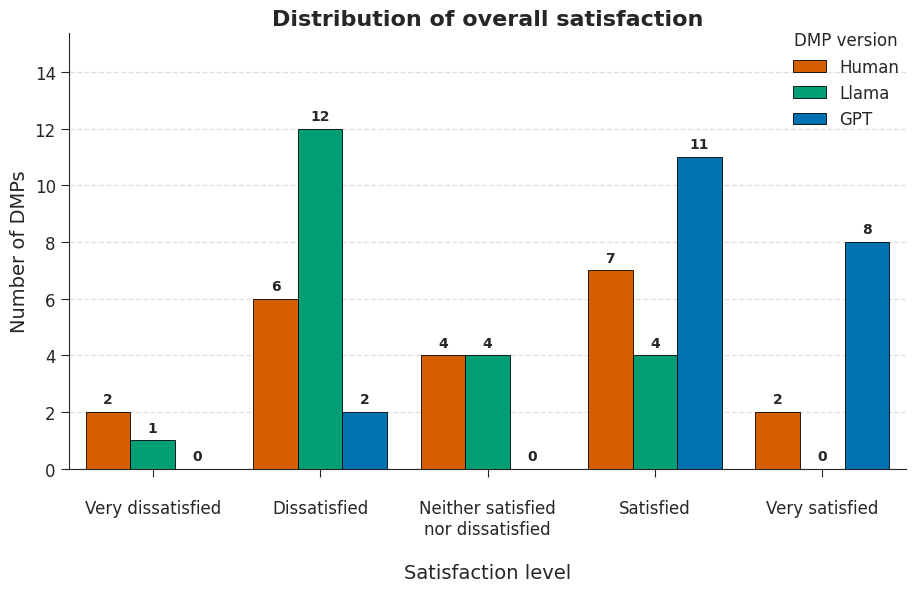

Saved figure: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/figures/overall_satisfaction_by_group.png
Step 5A OK


In [65]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(
    style="ticks",
    font="DejaVu Sans",
    rc={
        "font.size": 10,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,  
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",
    },
)

wong = {
    "Green": "#009E73",
    "Blue": "#0072B2",
    "Vermillion": "#D55E00",
}

model_order = ["Human", "Llama", "GPT"]
group_to_color = {
    "Human": wong["Vermillion"],
    "Llama": wong["Green"],
    "GPT": wong["Blue"],
}
palette_list = [group_to_color[m] for m in model_order]

df_plot = expanded.copy()

required_cols = {"participantId", "dmpName", "model", "overallSatisfaction"}
missing = sorted(required_cols - set(df_plot.columns))
if missing:
    raise KeyError(f"Missing required columns for Step 5A plot: {missing}")

df_plot["participantId"] = df_plot["participantId"].astype("string")
df_plot["dmpName"] = df_plot["dmpName"].astype("string")
df_plot = df_plot.drop_duplicates(subset=["participantId", "dmpName"]).copy()

df_plot = df_plot[df_plot["model"].isin(model_order)].copy()
df_plot["DMP version"] = df_plot["model"]

df_plot["overallSatisfaction"] = pd.to_numeric(df_plot["overallSatisfaction"], errors="coerce")
df_plot = df_plot[df_plot["overallSatisfaction"].between(1, 5)].copy()
df_plot["overallSatisfaction"] = df_plot["overallSatisfaction"].astype(int)

score_to_label = {
    1: "Very dissatisfied",
    2: "Dissatisfied",
    3: "Neither satisfied\nnor dissatisfied",
    4: "Satisfied",
    5: "Very satisfied",
}
df_plot["Satisfaction level"] = df_plot["overallSatisfaction"].map(score_to_label)

x_order = [
    "Very dissatisfied",
    "Dissatisfied",
    "Neither satisfied\nnor dissatisfied",
    "Satisfied",
    "Very satisfied",
]

counts = (
    df_plot.groupby(["Satisfaction level", "DMP version"])
           .size()
           .reset_index(name="Count")
)

all_idx = pd.MultiIndex.from_product(
    [x_order, model_order],
    names=["Satisfaction level", "DMP version"]
)
counts = (
    counts.set_index(["Satisfaction level", "DMP version"])
          .reindex(all_idx, fill_value=0)
          .reset_index()
)


fig, ax = plt.subplots(figsize=(10.8, 6.4))

sns.barplot(
    data=counts,
    x="Satisfaction level",
    y="Count",
    hue="DMP version",
    order=x_order,
    hue_order=model_order,
    palette=palette_list,
    saturation=1,
    dodge=True,
    edgecolor="black",
    linewidth=0.6,
    ax=ax,
)

for p in ax.patches:
    p.set_alpha(1.0)

ax.set_title("Distribution of overall satisfaction")
ax.set_xlabel("Satisfaction level", labelpad=18) 
ax.set_ylabel("Number of DMPs")
ax.tick_params(axis="x", pad=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ymax = (counts["Count"].max() * 1.28) if len(counts) else 1
ax.set_ylim(0, max(1, ymax))


for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.0f",
        padding=4,
        fontsize=10,
        fontweight="bold",
        clip_on=False,
    )

ax.grid(axis="y", linestyle="--", alpha=0.6)
sns.despine(ax=ax)


ax.legend(
    title="DMP version",
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1.0, 1.02),
    borderaxespad=0.0,
)


fig.subplots_adjust(bottom=0.22, top=0.90)
fig_path = FIG_DIR / "overall_satisfaction_by_group.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print("Saved figure:", fig_path.as_posix())
print("Step 5A OK")

# STEP 6 — Authorship guess correctness (Human vs LLM)


Authorship guess correctness counts:
is_correct   Guess correct  Guess incorrect
source_norm                                
Human                   14                7
Llama                   15                6
GPT                      3               18
Saved table: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/authorship_guess_correctness_counts.csv


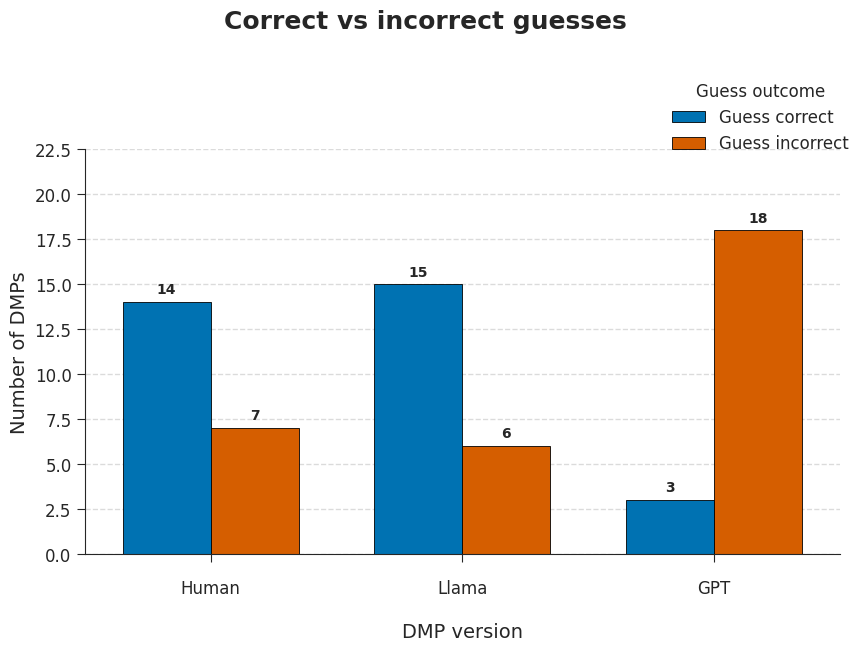

Saved figure: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/figures/authorship_guess_correctness_by_model.png
Step 6 OK


In [66]:
df = eval_clean.copy()

required_cols = {"dmpName", "overallAuthorshipGuess"}
missing = sorted(required_cols - set(df.columns))
if missing:
    raise KeyError(f"Missing required columns for Step 6: {missing}")

def extract_author_from_dmp(name):
    if pd.isna(name):
        return None
    s = str(name).strip().lower()
    if s.startswith("llama"):
        return "Llama"
    if s.startswith("gpt"):
        return "GPT"
    if s.startswith("human"):
        return "Human"
    return None

def expected_group_from_source(src):
    if src in ("Llama", "GPT"):
        return "llm"
    if src == "Human":
        return "human"
    return None

def normalize_guess(g):
    if not isinstance(g, str):
        return None
    s = g.strip().lower()
    if "human" in s:
        return "human"
    if ("llm" in s) or ("gpt" in s) or ("chatgpt" in s) or ("llama" in s) or ("ai" in s) or ("model" in s):
        return "llm"
    return None

df["source"] = df["dmpName"].apply(extract_author_from_dmp)
df["expected_group"] = df["source"].apply(expected_group_from_source)
df["guess_group"] = df["overallAuthorshipGuess"].apply(normalize_guess)

df["is_correct"] = np.where(
    df["expected_group"].notna()
    & df["guess_group"].notna()
    & (df["expected_group"] == df["guess_group"]),
    1, 0
)

df2 = df[df["expected_group"].notna() & df["guess_group"].notna()].copy()
df2["Guess outcome"] = df2["is_correct"].map({1: "Guess correct", 0: "Guess incorrect"})
df2["source_norm"] = df2["source"]

acc_counts = (
    df2.groupby("source_norm")["is_correct"]
       .value_counts()
       .unstack(fill_value=0)
       .rename(columns={1: "Guess correct", 0: "Guess incorrect"})
)

for col in ["Guess correct", "Guess incorrect"]:
    if col not in acc_counts.columns:
        acc_counts[col] = 0

acc_counts = acc_counts[["Guess correct", "Guess incorrect"]]
acc_counts = acc_counts.reindex([m for m in model_order if m in acc_counts.index])

print("\nAuthorship guess correctness counts:")
print(acc_counts)

table_path = TAB_DIR / "authorship_guess_correctness_counts.csv"
acc_counts.to_csv(table_path, encoding="utf-8")
print("Saved table:", table_path.as_posix())

plot_df = (
    acc_counts.reset_index()
              .melt(id_vars="source_norm", var_name="Guess outcome", value_name="Count")
              .rename(columns={"source_norm": "DMP version"})
)


# Seaborn style 

sns.set(
    style="ticks",
    font="DejaVu Sans",
    rc={
        "font.size": 10,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,  
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",
    },
)

hue_order = ["Guess correct", "Guess incorrect"]
palette_list = [wong["Blue"], wong["Vermillion"]]


# Plot

fig, ax = plt.subplots(figsize=(8.6, 6.6))  

sns.barplot(
    data=plot_df,
    x="DMP version",
    y="Count",
    hue="Guess outcome",
    order=acc_counts.index.tolist(),
    hue_order=hue_order,
    palette=palette_list,
    saturation=1,
    dodge=True,
    edgecolor="black",
    width=0.70,
    linewidth=0.6,
    ax=ax,
)

for p in ax.patches:
    p.set_alpha(1.0)


fig.suptitle("Correct vs incorrect guesses", fontsize=18, fontweight="bold", y=0.98)
ax.set_ylabel("Number of DMPs")
ax.tick_params(axis="x", pad=12)
ax.set_xlabel("DMP version", labelpad=18)
max_val = plot_df["Count"].max() if len(plot_df) else 1
ax.set_ylim(0, max(1, max_val) * 1.25)


for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=4, fontsize=10, fontweight="bold", clip_on=False)

ax.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(ax=ax)


handles, labels = ax.get_legend_handles_labels()
if ax.legend_ is not None:
    ax.legend_.remove()

fig.legend(
    handles,
    labels,
    title="Guess outcome",
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1.0, 0.88),
    borderaxespad=0.0,
)


fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.86])
fig_path = FIG_DIR / "authorship_guess_correctness_by_model.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved figure:", fig_path.as_posix())
print("Step 6 OK")

# STEP 7 — Element-level error + satisfaction analysis

In [67]:

def assert_no_duplicates(expanded_df: pd.DataFrame, tab_dir: Path) -> None:
    required = {"participantId", "dmpName", "elementTitle"}
    missing = sorted(required - set(expanded_df.columns))
    if missing:
        raise KeyError(f"Expanded table missing columns required for duplicate gate: {missing}")

    df = expanded_df.copy()
    df["participantId"] = df["participantId"].astype("string")
    df["dmpName"] = df["dmpName"].astype("string")
    df["elementTitle"] = df["elementTitle"].astype("string").fillna("MISSING_ELEMENT_TITLE")

    key_cols = ["participantId", "dmpName", "elementTitle"]
    key_dup_mask = df.duplicated(subset=key_cols, keep=False)
    n_key_dups = int(key_dup_mask.sum())

    hashable = df.copy()

    def to_hashable(x):
        if isinstance(x, (list, dict)):
            return json.dumps(x, sort_keys=True, ensure_ascii=False)
        return x

    obj_cols = hashable.select_dtypes(include=["object", "string"]).columns
    for c in obj_cols:
        hashable[c] = hashable[c].apply(to_hashable)

    exact_dup_mask = hashable.duplicated(keep=False)
    n_exact_dups = int(exact_dup_mask.sum())

    print("Duplicate gate check:")
    print(f" - Key duplicates {key_cols}: {n_key_dups}")
    print(f" - Exact duplicates (all columns): {n_exact_dups}")

    if n_key_dups > 0:
        p = tab_dir / "step7_block_key_duplicates.csv"
        df.loc[key_dup_mask].sort_values(key_cols).to_csv(p, index=False, encoding="utf-8")
        raise RuntimeError(f"STEP 7 blocked: key-level duplicates found. See: {p.as_posix()}")

    if n_exact_dups > 0:
        p = tab_dir / "step7_block_exact_duplicates.csv"
        df.loc[exact_dup_mask].sort_values(key_cols).to_csv(p, index=False, encoding="utf-8")
        raise RuntimeError(f"STEP 7 blocked: exact duplicates found. See: {p.as_posix()}")

    print("Duplicate gate passed: proceeding with Step 7.")


STEP7_TAB_DIR = TAB_DIR
STEP7_FIG_DIR = FIG_DIR

assert_no_duplicates(expanded, STEP7_TAB_DIR)



# Helper functions
def make_element_short(s):
    if pd.isna(s):
        return None
    m = re.search(r"(?i)\b(elem(?:ent|n|nt)?)\s*(\d+)", str(s))
    return f"Element {m.group(2)}" if m else None

def element_order_key(x):
    if not isinstance(x, str):
        return 1_000_000
    m = re.search(r"Element\s+(\d+)", x)
    return int(m.group(1)) if m else 1_000_000

def parse_errors(x):
    if isinstance(x, list):
        return x
    if pd.isna(x) or str(x).strip() == "":
        return []
    s = str(x)
    try:
        v = json.loads(s)
        return v if isinstance(v, list) else [str(v)]
    except Exception:
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else [str(v)]
        except Exception:
            return [s]

def clean_error_list(lst):
    keep = []
    for e in lst:
        s = str(e).strip()
        if re.fullmatch(r"(?i)none(\s*--.*)?", s):
            continue
        if re.fullmatch(r"(?i)no\s*errors?\s*seen", s):
            continue
        if s == "":
            continue
        keep.append(s)
    return keep

def simplify_error_label(lbl):
    return str(lbl).split("--", 1)[0].strip()

def extract_model(dmp):
    if pd.isna(dmp):
        return "Unknown"
    s = str(dmp).split("_")[0].strip().lower()
    if s == "gpt":
        return "GPT"
    if s == "llama":
        return "Llama"
    if s == "human":
        return "Human"
    return "Unknown"



# Preprocessing

work = expanded.copy()
if "satisfactionOrdinal" not in work.columns:
    sat_map = {
        "very dissatisfied": 1,
        "dissatisfied": 2,
        "neither dissatisfied or satisfied": 3,
        "satisfied": 4,
        "very satisfied": 5,
    }
    work["satisfactionOrdinal"] = (
        work["satisfactionScore"]
        .astype("string")
        .str.strip()
        .str.lower()
        .map(sat_map)
    )
    mapped_n = int(work["satisfactionOrdinal"].notna().sum())
    print(f"Created satisfactionOrdinal from satisfactionScore (mapped rows: {mapped_n} / {len(work)})")

work["elementShort"] = work["elementTitle"].apply(make_element_short)
work["parsedErrors"] = work["selectedErrors"].apply(parse_errors).apply(clean_error_list)
work["model"] = work["dmpName"].apply(extract_model)

model_types = ["GPT", "Llama", "Human"]



# Per-model outputs
for model in model_types:
    print(f"\nMODEL: {model}")
    df_model = work[work["model"] == model].copy()

    err_exp = (
        df_model
        .explode("parsedErrors")
        .assign(errorSimple=lambda d: d["parsedErrors"].fillna("").astype(str).map(simplify_error_label))
    )
    err_exp = err_exp[
        err_exp["errorSimple"].str.strip().ne("") &
        err_exp["errorSimple"].str.lower().ne("none")
    ]

    error_counts = (
        err_exp
        .groupby(["elementShort", "errorSimple"], dropna=False)
        .size()
        .reset_index(name="count")
    )
    error_counts["__ord"] = error_counts["elementShort"].map(element_order_key)
    error_counts = error_counts.sort_values(["__ord", "count"], ascending=[True, False]).drop(columns="__ord")
    error_counts.to_csv(STEP7_TAB_DIR / f"error_counts_{model}.csv", index=False, encoding="utf-8")

    error_matrix = (
        error_counts
        .pivot(index="errorSimple", columns="elementShort", values="count")
        .fillna(0)
        .astype(int)
    )
    if len(error_matrix.columns) > 0:
        error_matrix = error_matrix[sorted(error_matrix.columns, key=element_order_key)]
    error_matrix = error_matrix.sort_index()
    error_matrix.to_csv(STEP7_TAB_DIR / f"error_matrix_{model}.csv", encoding="utf-8")

    sat_stats = (
        df_model
        .dropna(subset=["elementShort", "satisfactionOrdinal"])
        .groupby("elementShort", as_index=False)["satisfactionOrdinal"]
        .agg(mean="mean", std="std", n="count", median="median")
    )
    sat_stats["__ord"] = sat_stats["elementShort"].map(element_order_key)
    sat_stats = sat_stats.sort_values("__ord").drop(columns="__ord").reset_index(drop=True)
    sat_stats.to_csv(STEP7_TAB_DIR / f"satisfaction_stats_{model}.csv", index=False, encoding="utf-8")

    top_errors = (
        error_counts
        .groupby("elementShort", as_index=False)
        .apply(lambda g: ", ".join(g.sort_values("count", ascending=False).head(3)["errorSimple"].tolist()))
        .reset_index(drop=True)
        .rename(columns={0: "topErrors"})
    )
    summary = sat_stats.merge(top_errors, on="elementShort", how="left")
    summary.to_csv(STEP7_TAB_DIR / f"element_summary_{model}.csv", index=False, encoding="utf-8")

   


element_labels = {
    "Element 1": "Types and Amount of Scientific Data; Data to be Preserved and Shared; Metadata and Documentation",
    "Element 2": "Tools, Software, and Code",
    "Element 3": "Standards",
    "Element 4": "Repository, Findability, and Availability Timeline",
    "Element 5": "Access, Distribution, Reuse, Controlled Access, Privacy, and Confidentiality",
    "Element 6": "Oversight of DMP",
}

all_stats = []
for model in model_types:
    df_stats = pd.read_csv(STEP7_TAB_DIR / f"satisfaction_stats_{model}.csv")
    df_stats["model"] = model
    all_stats.append(df_stats)

df_all = pd.concat(all_stats, ignore_index=True)
df_all["mean_std"] = df_all.apply(lambda r: f"{r['mean']:.1f}±{r['std']:.2f}", axis=1)

table = df_all.pivot(index="elementShort", columns="model", values="mean_std").reset_index()
table.insert(1, "elementField", table["elementShort"].map(element_labels))
table = table.sort_values("elementShort", key=lambda col: col.map(element_order_key))

table.columns.name = None
table = table.rename(columns={
    "elementShort": "elementNumber",
    "Llama": "Llama 3.3",
    "GPT": "GPT 4.1",
    "Human": "Human",
})

final_path = STEP7_TAB_DIR / "satisfaction_comparison_table.csv"
table.to_csv(final_path, index=False, encoding="utf-8")

print("\nSaved Step 7 outputs to:")
print(" - Tables :", STEP7_TAB_DIR.as_posix())
print(" - Figures:", STEP7_FIG_DIR.as_posix())
print(" - Comparison table:", final_path.as_posix())
print("Step 7 OK")

Duplicate gate check:
 - Key duplicates ['participantId', 'dmpName', 'elementTitle']: 0
 - Exact duplicates (all columns): 0
Duplicate gate passed: proceeding with Step 7.
Created satisfactionOrdinal from satisfactionScore (mapped rows: 377 / 378)

MODEL: GPT

MODEL: Llama

MODEL: Human

Saved Step 7 outputs to:
 - Tables : C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables
 - Figures: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/figures
 - Comparison table: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/satisfaction_comparison_table.csv
Step 7 OK


C:\Users\Nahid\AppData\Local\Temp\ipykernel_42796\1083746489.py:191: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(g.sort_values("count", ascending=False).head(3)["errorSimple"].tolist()))
C:\Users\Nahid\AppData\Local\Temp\ipykernel_42796\1083746489.py:191: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(g.sort_values("count", ascending=False).head(3)["err

# STEP 8 — Background (survey) analysis

In [68]:

import re
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# 8.1 Load + filter to evaluators
background_df = pd.read_csv(BG_FILE)
eval_df2 = pd.read_csv(EVAL_FILE)

if "participantId" not in background_df.columns:
    raise KeyError("Background file missing 'participantId'")
if "participantId" not in eval_df2.columns:
    raise KeyError("Evaluation file missing 'participantId'")

background_df = background_df.dropna(subset=["participantId"]).copy()
background_df["participantId"] = background_df["participantId"].astype("string")

eval_ids = eval_df2["participantId"].dropna().astype("string").unique()

df_bg = background_df[background_df["participantId"].isin(eval_ids)].copy()
N_true = int(df_bg["participantId"].nunique())
print(f"Filtered participants (evaluation cohort): {N_true}")

# Save filtered background
bg_filt_path = TAB_DIR / "background_filtered_to_evaluators_step8.csv"
df_bg.to_csv(bg_filt_path, index=False, encoding="utf-8")
print("Saved:", bg_filt_path.as_posix())

Filtered participants (evaluation cohort): 21
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/background_filtered_to_evaluators_step8.csv


# 8.2 Helpers

In [69]:



def wrap_two_lines(s: str, width: int = 42) -> str:
    return "\n".join(textwrap.wrap(str(s), width=width))

def parse_list(value):
    """Handle values like '{"A","B"}' or "['A','B']" or 'A,B'."""
    if pd.isna(value):
        return []
    text = str(value).strip()
    text = text.strip("{}[]")
    text = text.replace('"', "").replace("'", "")
    parts = re.split(r",|;|\|", text)
    return [p.strip() for p in parts if p.strip()]

def ordered_counts_from_series(series, order):
    """Return counts for an ordered categorical series + N responders for that panel."""
    responders = series.dropna().astype(str).str.strip()
    responders = responders[(responders != "") & (responders.str.lower() != "nan")]
    N_panel = int(responders.shape[0])

    cat = pd.Categorical(responders, categories=order, ordered=True)
    out = pd.Series(cat).value_counts(dropna=False).reindex(order).fillna(0).astype(int).reset_index()
    out.columns = ["Category", "Count"]
    return out, N_panel

# 8.3 Roles (multi-select) normalization

In [70]:


ROLE_CATEGORIES = {
    "Researcher": "Researcher (e.g., student, faculty, post-doctoral)",
    "Admin": "Research administrator / Program officer",
    "DataMgr": "Data manager / Data steward",
    "Librarian": "Librarian / Data librarian / Research support staff",
    "Other": "Other",
}

ROLE_KEYWORDS = {
    "researcher": ROLE_CATEGORIES["Researcher"],
    "student": ROLE_CATEGORIES["Researcher"],
    "faculty": ROLE_CATEGORIES["Researcher"],
    "post": ROLE_CATEGORIES["Researcher"],

    "administrator": ROLE_CATEGORIES["Admin"],
    "program officer": ROLE_CATEGORIES["Admin"],
    "program manager": ROLE_CATEGORIES["Admin"],

    "data manager": ROLE_CATEGORIES["DataMgr"],
    "data steward": ROLE_CATEGORIES["DataMgr"],

    "librarian": ROLE_CATEGORIES["Librarian"],
    "research support": ROLE_CATEGORIES["Librarian"],
}

def map_role_to_category(role_str):
    if not isinstance(role_str, str):
        return ROLE_CATEGORIES["Other"]
    t = role_str.lower()
    for k, cat in ROLE_KEYWORDS.items():
        if k in t:
            return cat
    return ROLE_CATEGORIES["Other"]

if "roles" not in df_bg.columns:
    raise KeyError("Background table missing required column 'roles' for Step 8 figure.")

role_rows = []
for pid, raw in zip(df_bg["participantId"], df_bg["roles"]):
    for r in parse_list(raw):
        role_rows.append({"participantId": pid, "Category": map_role_to_category(r)})

roles_long = pd.DataFrame(role_rows).drop_duplicates()
N_A = int(roles_long["participantId"].nunique()) if not roles_long.empty else 0

# Role summary table (multi-select)
roles_counts = roles_long["Category"].value_counts().reset_index()
roles_counts.columns = ["Role Category", "Selections"]

roles_counts["Participants"] = (
    roles_long.groupby("Category")["participantId"].nunique()
    .reindex(roles_counts["Role Category"])
    .values
)
roles_counts["Percent_of_participants"] = (roles_counts["Participants"] / N_true * 100).round(1)

roles_counts_path = TAB_DIR / "background_roles_summary.csv"
roles_counts.to_csv(roles_counts_path, index=False, encoding="utf-8")
print("Saved:", roles_counts_path.as_posix())

participant_roles = (
    roles_long[["participantId", "Category"]]
    .drop_duplicates()
    .groupby("participantId")["Category"]
    .apply(lambda s: ", ".join(sorted(s.unique())))
    .reset_index(name="Role Categories")
    .sort_values("participantId")
)
participant_roles_path = TAB_DIR / "background_roles_per_participant.csv"
participant_roles.to_csv(participant_roles_path, index=False, encoding="utf-8")
print("Saved:", participant_roles_path.as_posix())


Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/background_roles_summary.csv
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/background_roles_per_participant.csv


# 8.4 DMP count (ordered)

In [71]:

if "dmpCount" not in df_bg.columns:
    raise KeyError("Background table missing required column 'dmpCount' for Step 8 figure.")

df_b = df_bg.copy()
df_b["dmpCount"] = (
    df_b["dmpCount"]
    .astype(str)
    .str.replace("â€“", "–", regex=False)  # fix corrupted en-dash
    .str.strip()
)

df_b["dmpCount_clean"] = df_b["dmpCount"].replace({
    "2-3": "2–3",
    "4-5": "4–5",
    "More than five": "More than 5",
    "More than five DMPs": "More than 5",
})

dmp_order = ["1", "2–3", "4–5", "More than 5"]
b_counts, N_B = ordered_counts_from_series(df_b["dmpCount_clean"], dmp_order)

b_counts_path = TAB_DIR / "background_dmpCount_summary.csv"
b_counts.assign(Percent=(b_counts["Count"] / max(1, N_B) * 100).round(1)).to_csv(
    b_counts_path, index=False, encoding="utf-8"
)
print("Saved:", b_counts_path.as_posix())


Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/background_dmpCount_summary.csv


# 8.5 DMP review frequency (ordered)

In [72]:

if "dmpReviewFrequency" not in df_bg.columns:
    raise KeyError("Background table missing required column 'dmpReviewFrequency' for Step 8 figure.")

freq_order = ["Weekly or more often", "About once a month", "Every few months", "Once or twice a year"]
c_counts, N_C = ordered_counts_from_series(df_bg["dmpReviewFrequency"], freq_order)

c_counts_path = TAB_DIR / "background_dmpReviewFrequency_summary.csv"
c_counts.assign(Percent=(c_counts["Count"] / max(1, N_C) * 100).round(1)).to_csv(
    c_counts_path, index=False, encoding="utf-8"
)
print("Saved:", c_counts_path.as_posix())


Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/background_dmpReviewFrequency_summary.csv


# 8.6 Familiarity with NIH DMP requirements (ordered)

In [73]:

if "dmsFamiliarity" not in df_bg.columns:
    raise KeyError("Background table missing required column 'dmsFamiliarity' for Step 8 figure.")

fam_order = ["Slightly familiar", "Somewhat familiar", "Moderately familiar", "Extremely familiar"]
d_counts, N_D = ordered_counts_from_series(df_bg["dmsFamiliarity"], fam_order)

d_counts_path = TAB_DIR / "background_dmsFamiliarity_summary.csv"
d_counts.assign(Percent=(d_counts["Count"] / max(1, N_D) * 100).round(1)).to_csv(
    d_counts_path, index=False, encoding="utf-8"
)
print("Saved:", d_counts_path.as_posix())

Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/outputs/human-evaluation/tables/background_dmsFamiliarity_summary.csv


# 8.7 Plot 

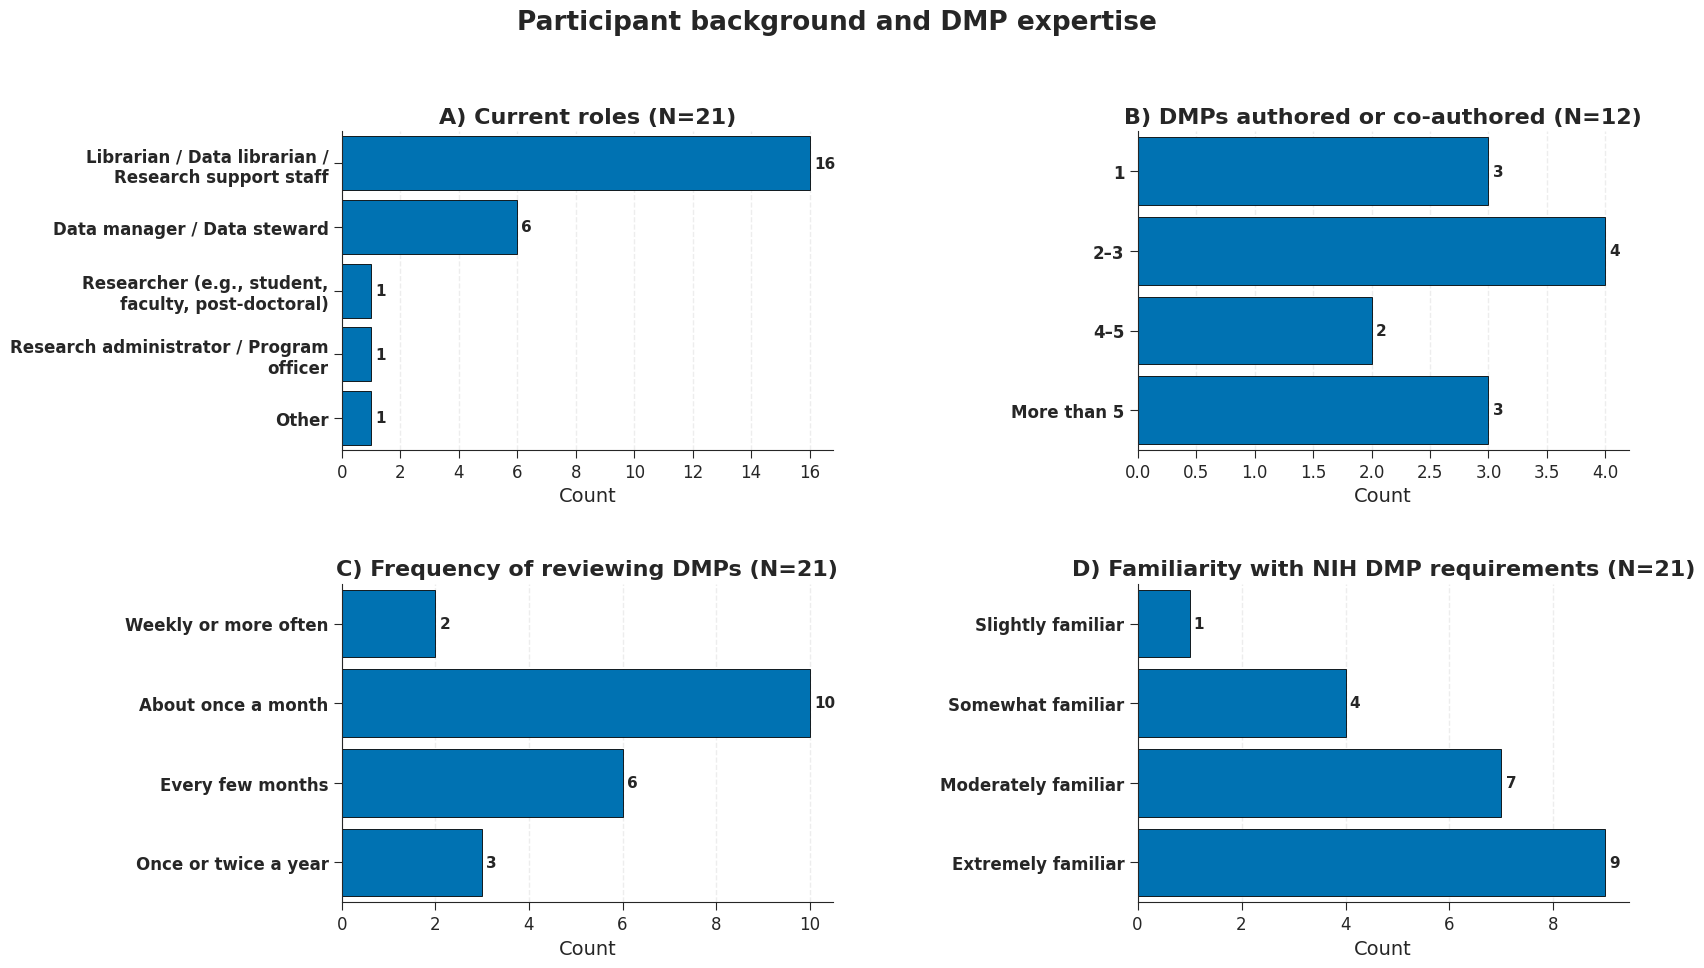

Step 8 OK


In [77]:


def wrap_panelA_label(s: str, width: int = 34) -> str:
    """
    Wrap long role labels for Panel A without breaking words.
    """
    if s is None:
        return ""
    s = str(s).strip()
    if not s or s.lower() == "nan":
        return ""
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))
    
sns.set(
    style="ticks",
    font="DejaVu Sans",
    rc={
        "font.size": 10,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 16,  
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",
    },
)

ONE_COLOR = "#0072B2"

# Panel A counts + wrapped labels (use your latest wrapper)
roles_counts_plot = roles_long["Category"].value_counts().reset_index()
roles_counts_plot.columns = ["Category", "Count"]
roles_counts_plot["Category_wrapped"] = roles_counts_plot["Category"].apply(wrap_panelA_label)
roles_sorted = roles_counts_plot.sort_values("Count", ascending=False)


def barh_panel(ax, data, y_col, title, y_order=None, bold_ylabels=False):
    sns.barplot(
        data=data,
        x="Count",
        y=y_col,
        order=y_order,
        color=ONE_COLOR,
        saturation=1,
        edgecolor="black",
        linewidth=0.6,
        width=0.85,
        ax=ax,
    )

    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel("")

    if bold_ylabels:
        for tick in ax.get_yticklabels():
            tick.set_fontweight("bold")

    for c in ax.containers:
        ax.bar_label(c, fmt="%.0f", padding=3, fontsize=11, fontweight="bold")

    ax.grid(axis="x", linestyle="--", alpha=0.35)  
    sns.despine(ax=ax)


fig, axes = plt.subplots(2, 2, figsize=(16.5, 9.4))  
axes = axes.ravel()

fig.suptitle(
    "Participant background and DMP expertise\n\n\n",  
    fontsize=19,
    fontweight="bold",
    y=1.03,
)

barh_panel(
    axes[0],
    roles_sorted,
    "Category_wrapped",
    f"A) Current roles (N={N_A})",
    y_order=roles_sorted["Category_wrapped"].tolist(),
    bold_ylabels=True,
)

barh_panel(
    axes[1],
    b_counts,
    "Category",
    f"B) DMPs authored or co-authored (N={N_B})",
    y_order=dmp_order,
    bold_ylabels=True,
)

barh_panel(
    axes[2],
    c_counts,
    "Category",
    f"C) Frequency of reviewing DMPs (N={N_C})",
    y_order=freq_order,
    bold_ylabels=True,
)

barh_panel(
    axes[3],
    d_counts,
    "Category",
    f"D) Familiarity with NIH DMP requirements (N={N_D})",
    y_order=fam_order,
    bold_ylabels=True,
)


fig.subplots_adjust(
    left=0.20,
    right=0.98,
    top=0.90,
    bottom=0.08,
    wspace=0.62,
    hspace=0.42,
)

fig_path = FIG_DIR / "participants_background_dmp_expertise_horizontal_2x2.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight", pad_inches=0.02, facecolor="white")
plt.show()
plt.close(fig)

print("Step 8 OK")


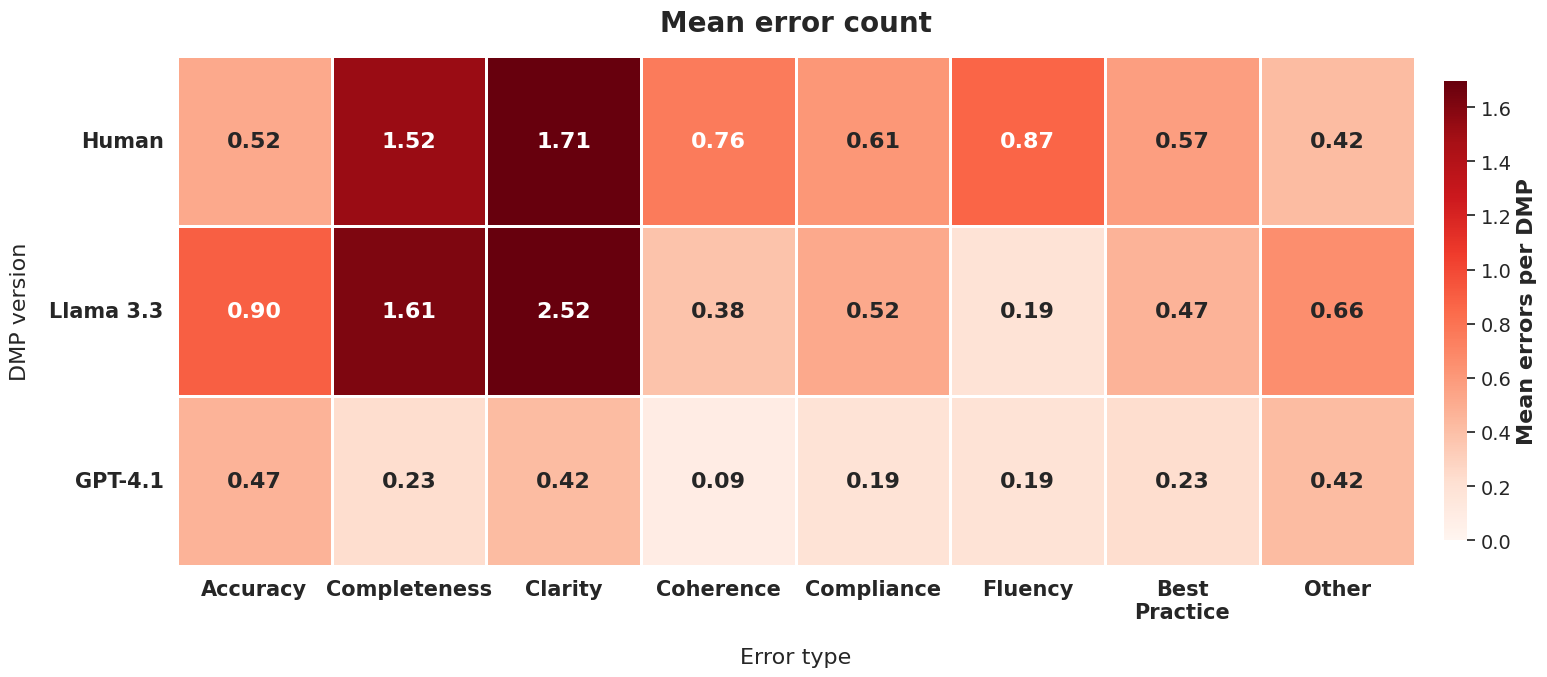

Saved heatmap to: C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\outputs\human-evaluation\figures\error_heatmap_by_model_pub.png
Color scale used: vmin=0.0, vmax=1.695 (95th percentile)


In [78]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data (from your table)

data = [
    ["Human",     0.52, 1.52, 1.71, 0.76, 0.61, 0.87, 0.57, 0.42],
    ["Llama 3.3", 0.90, 1.61, 2.52, 0.38, 0.52, 0.19, 0.47, 0.66],
    ["GPT-4.1",   0.47, 0.23, 0.42, 0.09, 0.19, 0.19, 0.23, 0.42],
]
cols = [
    "DMP version", "Accuracy", "Completeness", "Clarity", "Coherence",
    "Compliance", "Fluency", "Best Practice", "Other"
]
df_hm = pd.DataFrame(data, columns=cols).set_index("DMP version")

# Stable row/column order (publication)
row_order = ["Human", "Llama 3.3", "GPT-4.1"]
col_order = ["Accuracy", "Completeness", "Clarity", "Coherence",
             "Compliance", "Fluency", "Best Practice", "Other"]
df_hm = df_hm.reindex(index=row_order, columns=col_order)


# Styling 

sns.set(
    style="white",
    font="DejaVu Sans",
    rc={
        "font.size": 14,          
        "axes.titlesize": 20,     
        "axes.titleweight": "bold",
        "axes.labelsize": 16,     
        "xtick.labelsize": 15,    
        "ytick.labelsize": 15,    
    },
)

x_labels = ["Accuracy", "Completeness", "Clarity", "Coherence",
            "Compliance", "Fluency", "Best\nPractice", "Other"]


# vmin / vmax 
vals = df_hm.to_numpy().ravel()
vmin = 0.0
vmax = float(np.percentile(vals, 95))  


# Heatmap

fig, ax = plt.subplots(figsize=(17, 7))
hm = sns.heatmap(
    df_hm,
    ax=ax,
    cmap="Reds",
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=".2f",
    linewidths=1.0,
    linecolor="#FFFFFF",
    cbar=True,
    cbar_kws={"label": "Mean errors per DMP", "shrink": 0.90, "pad": 0.02},
    annot_kws={"fontsize": 16, "fontweight": "bold"}, 
)

ax.set_title("Mean error count", pad=18)
ax.set_xlabel("Error type", fontsize=16, labelpad=18)
ax.set_ylabel("DMP version", fontsize=16, labelpad=14)
ax.set_xticklabels(x_labels, rotation=0, ha="center", fontweight="bold")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontweight="bold")

# Colorbar label/ticks 
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Mean errors per DMP", fontsize=16, fontweight="bold")  
fig.tight_layout()
fig_path = FIG_DIR / "error_heatmap_by_model_pub.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved heatmap to:", fig_path)
print(f"Color scale used: vmin={vmin}, vmax={vmax:.3f} (95th percentile)")
